In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import yfinance as yf
import time
import sys
import math
from sklearn.manifold import TSNE

sys.path.append('Modulos')
import VAE
import ETL
import PLOT
# import GAN
import LSTM
import OPT

In [3]:
# DATA RETRIEVAL

etl = ETL.ETL('SAN.MC') # Banco Santander Symbol

In [4]:
# DATA VISUALIZATION (It could be required !pip install nbformat)

# !pip install nbformat
graficos = PLOT.Plot_data(etl)
graficos.plot_tech()
graficos.plot_fft()

c:\Users\34722\anaconda3\envs\AI-tf\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
# VAE OPTIMIZATION

path_vae = 'C:\\Users\\34722\\Desktop\\Stock_Prediction\\Guardados\\VAE_hyperparameters\\'
opt = OPT.OPT_VAE(etl.scaled_train_tensor,  etl.scaled_val_tensor)
opt.run_optimization(trials=10, study_number=2, path=path_vae)
opt.best_params(study_number=2, path=path_vae)

Epoch 1/200
125/125 [==============================] - 3s 5ms/step - loss: 15.8383 - val_loss: 10.6240
Epoch 2/200
125/125 [==============================] - 0s 3ms/step - loss: 8.7658 - val_loss: 6.0249
Epoch 3/200
125/125 [==============================] - 0s 3ms/step - loss: 4.8315 - val_loss: 3.5799
Epoch 4/200
125/125 [==============================] - 0s 2ms/step - loss: 2.8378 - val_loss: 2.1516
Epoch 5/200
125/125 [==============================] - 0s 2ms/step - loss: 1.6114 - val_loss: 1.2362
Epoch 6/200
125/125 [==============================] - 0s 2ms/step - loss: 0.8942 - val_loss: 0.7317
Epoch 7/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4730 - val_loss: 0.4524
Epoch 8/200
125/125 [==============================] - 0s 2ms/step - loss: 0.2533 - val_loss: 0.3109
Epoch 9/200
125/125 [==============================] - 0s 3ms/step - loss: 0.1479 - val_loss: 0.2520
Epoch 10/200
125/125 [==============================] - 0s 2ms/step - loss: 0.1022 - val_

INFO:tensorflow:Assets written to: C:\Users\34722\Desktop\Guardados\VAE_saves\Train_1\assets


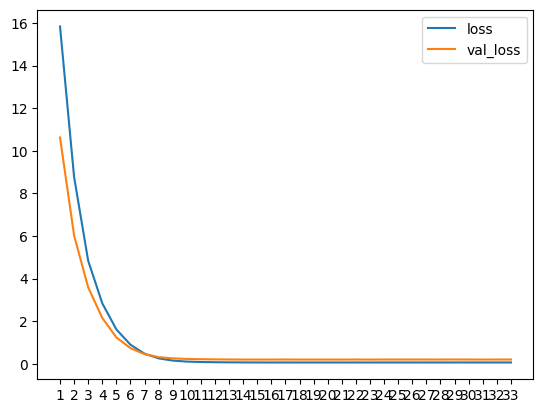

Training Time: 12.77 s
Best epoch: 22
val_loss in epoch 22: 0.1965

Train tensor shape: (4000, 49), Validation tensor shape: (500, 49), Test tensor shape: (500, 49)

Transformed tensor for next process:

X_train shape: (3990, 10, 49), Y_train shape: (3990, 1)
X_val shape: (490, 10, 49), y_val shape: (490, 1)
X_test shape: (490, 10, 49), Y_test shape: (490, 1)


In [5]:
# VAE TRAINING

# Relevant dimensions
original_dim = etl.scaled_train_tensor.shape[1]
n_examples = etl.scaled_train_tensor.shape[0]
batch_size = 32
steps_by_epoch = math.ceil(n_examples/batch_size)

# Model and optimizer hyperparameters
hyperparameters = {
    'original_dim': original_dim,
    'latent_dim': 16,
    'layer_dims': [32, 32, 32],
    'dropout_rate': 0.5,
    'momentum': 0.99,
    'kl_beta': 1,
    'alpha_lrelu': 0.5,
    'l1': 0.015,
    'l2': 0.015
}
lr_hyperparameters = {
    'initial_learning_rate': 0.0015,
    'decay_steps': steps_by_epoch,
    'decay_rate': 0.9950
}

# Create an instance of the variational autoencoder
vae = VAE.VariationalAutoEncoder(**hyperparameters)

# Create the optimizer with the corresponding exponential decay learning rate schedule
lr_schedule_exp = tf.keras.optimizers.schedules.ExponentialDecay(**lr_hyperparameters)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_exp)

# Compile the model, train it with an EarlyStopping callback, and save it in 'VAE_saves'
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10, restore_best_weights=True)
tic = time.time()
history = vae.fit(etl.scaled_train_tensor, etl.scaled_train_tensor, epochs=200, batch_size=batch_size, callbacks=[callback], validation_data=(etl.scaled_val_tensor, etl.scaled_val_tensor), verbose=1) # x=y ya que estamos entrenando al VAE completo
toc = time.time()
vae.save('C:\\Users\\34722\\Desktop\\Stock_Prediction\\Guardados\\VAE_saves\\Train_1')

# Plot training results (loss functions)
plt.xticks(range(len(history.history['loss'])), [str(i+1) for i in range(len(history.history['loss']))])
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

print('Training Time: {:.2f} s'.format(toc-tic))
print('Best epoch: {}'.format(callback.best_epoch))
print('val_loss in epoch {}: {:.4f}\n'. format(callback.best_epoch, history.history['val_loss'][callback.best_epoch]))

# Get the tensor of the encoded latent space z from the trained encoder and other necessary data for the next phase
_,_,z = vae.encoder(etl.scaled_data_tensor) # Use the scaled dataset to generate z data in the latent space
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler_X, scaler_Y = VAE.VAE2GANdata(etl.data_tensor, z, use_z=True, val_size = 0.1, test_size = 0.1, timesteps=10) # Create the complete dataset for GAN or LSTM with z and the original dataset and scale it

In [6]:
# MODEL LOADING (can be loaded like this since the instance itself is the model)

vae = tf.keras.models.load_model('C:\\Users\\34722\\Desktop\\Stock_Prediction\\Guardados\\VAE_saves\\Train_1') 
_,_,z = vae.encoder(etl.scaled_data_tensor)
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler_X, scaler_Y = VAE.VAE2GANdata(etl.data_tensor, z, use_z=True, val_size = 0.1, test_size = 0.1, timesteps=10) # Creamos el dataset completo para el GAN o LSTM con z y el dataset original y lo escalamos

Train tensor shape: (4000, 49), Validation tensor shape: (500, 49), Test tensor shape: (500, 49)

Transformed tensor for next process:

X_train shape: (3990, 10, 49), Y_train shape: (3990, 1)
X_val shape: (490, 10, 49), y_val shape: (490, 1)
X_test shape: (490, 10, 49), Y_test shape: (490, 1)


In [ ]:
# OPTIMIZATION OF THE RECURRENT MODEL

path_lstm = 'C:\\Users\\34722\\Desktop\\Stock_Prediction\\Guardados\\LSTM_hyperparameters\\'
opt = OPT.OPT_LSTM(etl.data_tensor, z)
opt.run_optimization(global_trials=2, local_trials=2, study_number=2, path=path_lstm)
opt.best_params()

Epoch 1/30
125/125 [==============================] - 11s 49ms/step - loss: 34.9453 - mean_absolute_percentage_error: 56410.2695 - mean_absolute_error: 1.0882 - root_mean_squared_error: 1.4262 - val_loss: 24.3781 - val_mean_absolute_percentage_error: 330.3766 - val_mean_absolute_error: 0.0812 - val_root_mean_squared_error: 0.0978
Epoch 2/30
  3/125 [..............................] - ETA: 4s - loss: 25.1921 - mean_absolute_percentage_error: 178.5579 - mean_absolute_error: 0.7702 - root_mean_squared_error: 0.9742

c:\Users\34722\anaconda3\envs\AI-tf\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



125/125 [==============================] - 5s 41ms/step - loss: 18.1757 - mean_absolute_percentage_error: 11298.8955 - mean_absolute_error: 0.5095 - root_mean_squared_error: 0.6632 - val_loss: 12.2542 - val_mean_absolute_percentage_error: 1044.4117 - val_mean_absolute_error: 0.1825 - val_root_mean_squared_error: 0.2388
Epoch 3/30
125/125 [==============================] - 5s 42ms/step - loss: 8.9652 - mean_absolute_percentage_error: 155918.9844 - mean_absolute_error: 0.2627 - root_mean_squared_error: 0.3401 - val_loss: 6.2317 - val_mean_absolute_percentage_error: 885.4077 - val_mean_absolute_error: 0.1550 - val_root_mean_squared_error: 0.2028
Epoch 4/30
125/125 [==============================] - 6s 44ms/step - loss: 4.6435 - mean_absolute_percentage_error: 162742.8906 - mean_absolute_error: 0.1703 - root_mean_squared_error: 0.2187 - val_loss: 3.3649 - val_mean_absolute_percentage_error: 1004.5968 - val_mean_absolute_error: 0.2172 - val_root_mean_squared_error: 0.2515
Epoch 5/30
125/125

INFO:tensorflow:Assets written to: C:\Users\34722\Desktop\Guardados\LSTM_saves\Train_1\assets


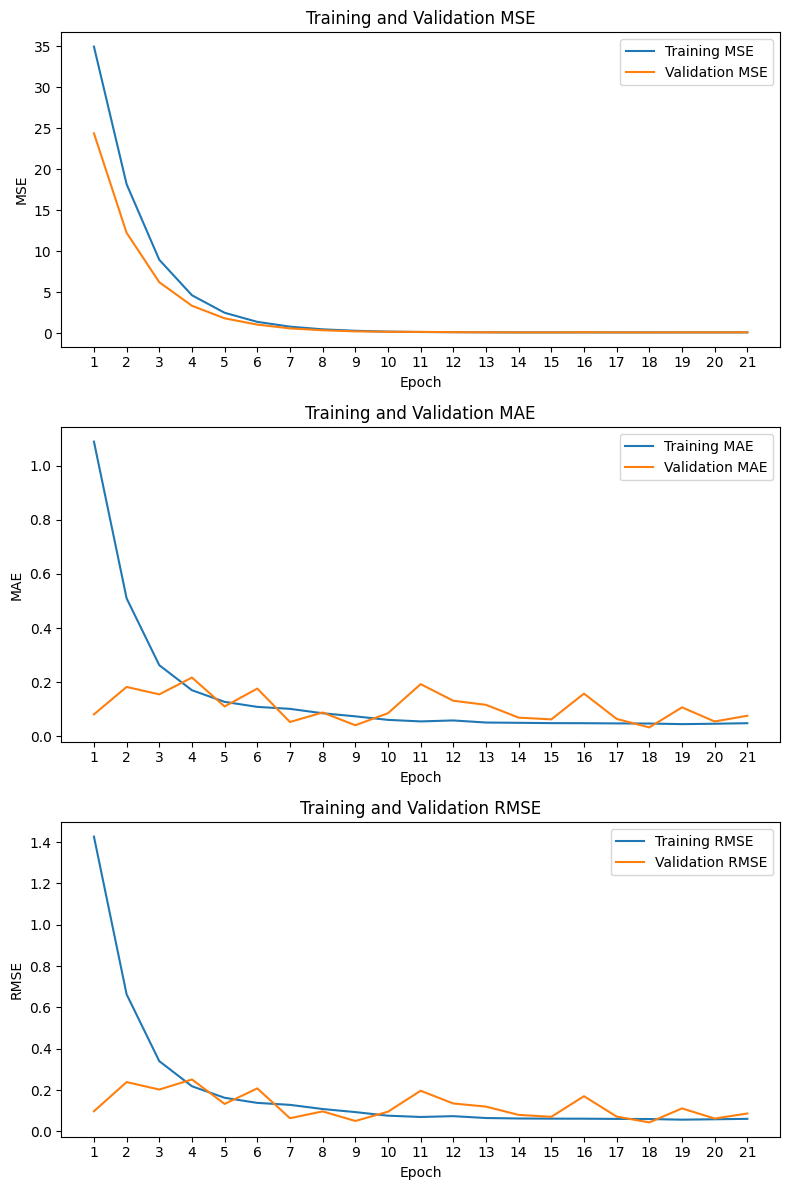

In [7]:
# TRAINING OF THE RECURRENT MODEL
batch_size = 32
n_examples = X_train.shape[0]
steps_by_epoch = math.ceil(n_examples / batch_size)
hyperparameters = {
    'n_features': X_train.shape[2],
    'timesteps': X_train.shape[1],
    'layers_type': 'LSTM',
    'model_layer_dims': [200,200],
    'momentum': 0.99,
    'dropout_rate': 0.5,
    'initial_lr': 0.0015,
    'decay_steps': steps_by_epoch,
    'decay_rate': 0.9995,
    'kernel_initializer': 'glorot_uniform',
    'l1_factor': 0.0015,
    'l2_factor': 0.0015,
    'bidirectional': True
}

lstm = LSTM.StockPriceLSTM(**hyperparameters)
path_checkpoints = 'C:\\Users\\34722\\Desktop\\Stock_Prediction\\Guardados\\LSTM_training_checkpoints'
tic = time.time()
history = lstm.train(X_train, Y_train, X_val, Y_val, epochs=30, batch_size=batch_size, path=path_checkpoints, patience=3) 
# In my experience, more patience is too much. It is not necessary
# With 30 epochs is enough (it sees many data in each epoch and learns). It's rare for it to go without callback to the end.
toc = time.time()
print('\nTraining Time: {:.2f} s'.format(toc-tic))
print('\nBest epoch: {}'.format(lstm.early_stopping.best_epoch))
print('\nval_loss in epoch {}: {:.4f}\n'. format(lstm.early_stopping.best_epoch, history.history['val_loss'][lstm.early_stopping.best_epoch]))

# Save the trained model for future use (in addition to periodic checkpoints)
path_save = 'C:\\Users\\34722\\Desktop\\Stock_Prediction\\Guardados\\LSTM_saves\\Train_1'
lstm.save_model(path_save)

# Plot training history metrics
lstm.plot_training_history(history=history)

In [8]:
# USE OF THE RECURRENT MODEL (PREDICTIONS) (*CHANGE HYPERPARAMETERS IF TRAINING IS CHANGED*)

# First create an instance and load the saved, already trained model
path_save = 'C:\\Users\\34722\\Desktop\\Stock_Prediction\\Guardados\\LSTM_saves\\Train_1'

batch_size = 32
n_examples = X_train.shape[0]
steps_by_epoch = math.ceil(n_examples / batch_size)
hyperparameters = {
    'n_features': X_train.shape[2],
    'timesteps': X_train.shape[1],
    'layers_type': 'LSTM',
    'model_layer_dims': [200,200],
    'momentum': 0.99,
    'dropout_rate': 0.5,
    'initial_lr': 0.0015,
    'decay_steps': steps_by_epoch,
    'decay_rate': 0.9995,
    'kernel_initializer': 'glorot_uniform',
    'l1_factor': 0.0015,
    'l2_factor': 0.0015,
    'bidirectional': True
}

lstm = LSTM.StockPriceLSTM(**hyperparameters)
lstm.load_model(path_save)

Y_train_pred = lstm.predict(X_train)
Y_val_pred = lstm.predict(X_val)
Y_test_pred = lstm.predict(X_test)
print('\nY_train_pred shape = {}, Y_val_pred shape = {}, Y_test_pred shape = {}'.format(Y_train_pred.shape, Y_val_pred.shape, Y_test_pred.shape))

16/16 [==============================] - 0s 14ms/step

Y_train_pred shape = (3990, 1), Y_val_pred shape = (490, 1), Y_test_pred shape = (490, 1)


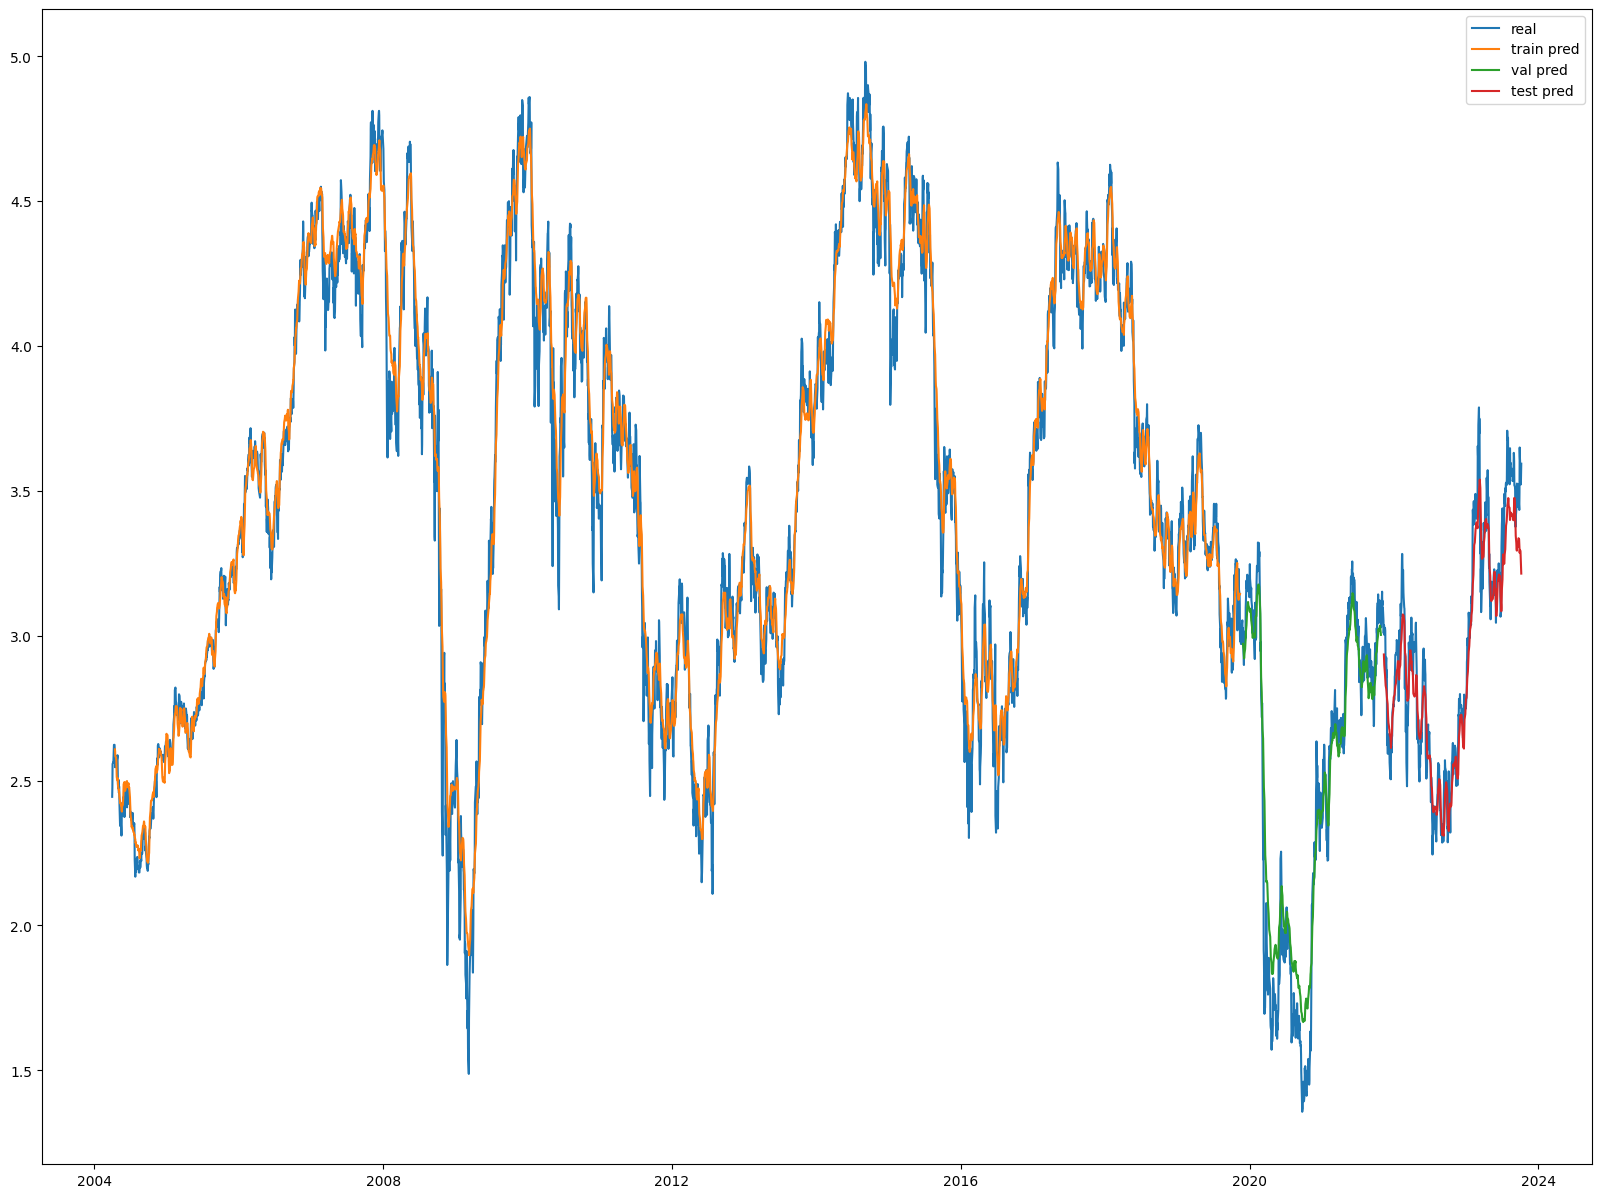

In [9]:
# EXAMPLE OF DATA DESCALING FOR FINAL REVIEW AND REPRESENTATION
"""
COMMENT ON THE RESULTS:
A simple LSTM network that takes the Close prices themselves as training data will produce a graph below much more consistent with the real data, having a lower error. 
This does not mean that the model is better. If we zoom in, we would discoverthat in detail, the model fails, as it essentially 'predicts' by copying the stock value 
from the previous day (in reality, we know that the marketdoesn't work that way).
By adding many more data and indicators that make stock prediction more possible (more likely because they are the data on which investors base their decisions
so we would 'guess' the future price by mimicking what they do rather than a real relationship between inputs and outputs), the training of the model becomes much more complex.
It is more difficult for the model to converge correctly in the last epochs, something that is evident when looking at the graphs, and we need that.
"""

y_train = scaler_Y.inverse_transform(Y_train_pred)
y_val = scaler_Y.inverse_transform(Y_val_pred)
y_test = scaler_Y.inverse_transform(Y_test_pred)

datosreales = yf.Ticker('SAN.MC').history(period='max')['Close'][-5000:]

plt.figure(figsize=(20,15))
index = np.arange(0, len(y_train), 1).reshape(-1,1)
index2 = np.arange(len(y_train), len(y_train)+len(y_val), 1).reshape(-1,1)
plt.plot(etl.dates, datosreales, label='real')
plt.plot(etl.dates[-4990:-1000], y_train, label='train pred')
plt.plot(etl.dates[-990:-500], y_val, label='val pred')
plt.plot(etl.dates[-490:], y_test, label='test pred')
plt.legend()
plt.show()

In [ ]:
# BIDIMENSIONAL REPRESENTATION OF THE Z TENSOR OF THE LATENT SPACE GENERATED BY THE VAE (*REVIEW*)

# An instance of T-SNE with the desired number of components
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)

# Fit T-SNE to data
Z_tsne = tsne.fit_transform(z)

# Create labels
etiquetas = [f'Etiqueta{i}' for i in range(50)]
colores = np.arange(5000)

# Create a scatter plot to visualize the results
plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1],c=colores, cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()

In [ ]:
# GAN TRAINING (*INCOMPLETE*)

import time
gan = GAN.StockPriceGAN(timesteps=X_train.shape[1], n_features=X_train.shape[2])
tic = time.time()
dictionary, generated_df = gan.train(X_train, Y_train, epochs=8, batch_size=64)
toc = time.time()
print(f'Training time: {toc-tic} s')

df = pd.DataFrame(dictionary)
df.to_csv('GAN_training.csv', index=False)

plt.plot(df.Epoch, df.g_loss, label='g_loss')
plt.plot(df.Epoch, df.d_loss, label='d_loss')
plt.legend()
plt.show()

In [ ]:
# VISUALIZATION OF GAN PREDICTIONS (*INCOMPLETE*)

# REAL AND PREDICTED LINES PLUS TOTAL ERROR
Y_pred = gan.generator(X_train)
print(Y_pred.shape, Y_train.shape)
mse = np.square(np.subtract(Y_pred, Y_train)).mean()
print(mse)

plt.figure(figsize=(20,15))
plt.plot(range(len(Y_train)), Y_train, label='y_real')
plt.plot(range(len(Y_pred)), Y_pred, label='y_predicted')
plt.legend()
plt.show()

# PREDICTIONS THROUGHOUT TRAINING
for epoch in generated_df.columns:
    generated_df[epoch] = scaler_Y.inverse_transform(tf.reshape(generated_df[epoch],shape=(-1,1)))
Y_train = scaler_Y.inverse_transform(Y_train)

plt.figure(figsize=(20,15))
for epoch in range(gan.current_epoch):
    if (epoch) % 5 == 0:
        plt.plot(generated_df.index, generated_df.iloc[:,epoch-1], label='epoch'+str(epoch+1))
plt.plot(generated_df.index, Y_train, label='real')
plt.legend()
plt.show()

In [ ]:
# EXAMPLES OF LOADING AND SAVING DATA FOR INTRA-MODULE TESTING

# # LOAD
# X_train = np.empty((3990, 10, 82))
# for i in range(10):
#     X_train[:,i,:] = np.loadtxt(f'C:\\Users\\34722\\Desktop\\Stock_Prediction\\Data\\X_train{i}.txt')
# Y_train = np.loadtxt('C:\\Users\\34722\\Desktop\\Stock_Prediction\\Data\\Y_train.txt').reshape(-1,1)

# X_val = np.empty((490, 10, 82))
# for i in range(10):  
#     X_val[:,i,:] = np.loadtxt(f'C:\\Users\\34722\\Desktop\\Stock_Prediction\\Data\\X_val{i}.txt')
# Y_val = np.loadtxt('C:\\Users\\34722\\Desktop\\Stock_Prediction\\Data\\Y_val.txt').reshape(-1,1)